# Recurrent Neural Nets Bach

In [26]:
import os 
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from glob import glob
import seaborn as  sns
import matplotlib.pyplot as plt

In [2]:
tf.autograph.set_verbosity(
    0, alsologtostdout=False
)

## GLOBAL PARAMETERS

In [3]:
DATA_DIR = "../../data/bach"

In [4]:
TRAIN_DIR = "../../data/bach/train"

In [5]:
TEST_DIR = "../../data/bach/test"

In [6]:
VALID_DIR = "../../data/bach/valid"

In [7]:
TIME_STAMPS = 8

In [8]:
INPUT_FEATURES = 4

In [9]:
BATCH_SIZE = 32

## Inspecting the data

__Notes:__  
0. A chorale seems to be some kind of melody. So a song consists of multiple chorales?
1. Each number represents a note - called MIDI numbers. E.G. 66 = F#
2. Each row represents a time stamp
3. Each chorale is 100 to 640 time stemps long. 

__Objective:__ 
1. Train a model that can predict the next time stamp (4 notes)
2. Use this model to generate batch like music (One note at the time)

In [10]:
file_lst = glob(os.path.join(DATA_DIR, "train/*.csv"))

In [11]:
df = pd.read_csv(file_lst[0])

In [12]:
df.head()

,note0,note1,note2,note3
0,68,64,59,52
1,68,64,59,52
2,68,64,59,52
3,68,64,59,52
4,73,64,57,57


#### Chroales differ in their size (100-640)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   note0   260 non-null    int64
 1   note1   260 non-null    int64
 2   note2   260 non-null    int64
 3   note3   260 non-null    int64
dtypes: int64(4)
memory usage: 8.2 KB


In [14]:
pd.read_csv(file_lst[3]).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   note0   240 non-null    int64
 1   note1   240 non-null    int64
 2   note2   240 non-null    int64
 3   note3   240 non-null    int64
dtypes: int64(4)
memory usage: 7.6 KB


### Building the data pipeline

__Consideration__:
1. 0 Stands for not hitting a note on the piano. It's a pause. Pauses are importend for the melody so they will not be filtered out  
2. Network-Architecture     
    2.1 It must be a Seq2Seq Model   
    2.2. Time Stamps/Input Size should be adjusted by needs.   
    2.3 Output-Size must be 4  
    
3. Does normalization makes sense?   
    3.1 Normalization makes sense if we are using Gradient-Descent  
    3.2 Working with Distances  
    3.3 Using Regularization Techniques  
    
4. Whats gonna be our objective (Y):  
    4.1 It would make sense to treat every following note in the dataset as Y 

5. Convention
    5.1 Training an RNN  [Batch_size, time_stamps, num_features]

In [20]:
data =  [pd.read_csv(x).values for x in file_lst] # Basically a ragged list. Each batch has a different length <-> This can not be putt into an np.array

In [21]:
batches_len = [len(x) for x in data]

In [29]:
np.mean(batches_len)

241.1703056768559

In [31]:
np.median(batches_len) # Most of the chroales have a length of 228 following chords. Could be the time stamp

228.0

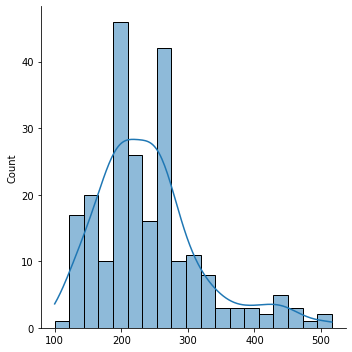

In [28]:
plt.Figure(figsize = (20,20))
sns.displot(batches_len, kde = True)

# Bringing the data into the right shape

### Filtering out time series which above the median

In [61]:
data = [x for x in data if len(x)<=228]

In [70]:
def add_padding(series, time_stamp_lim):
    time_stamps, num_features = series.shape
    new_series = np.zeros((time_stamp_lim, num_features))
    new_series[:time_stamps] = series
    return new_series

In [79]:
data = np.array([add_padding(x, 228) for x in data]) # Now each time series is 228 time stamps long

In [81]:
data.shape # 120 Time series each 228 Time stamps long containing each 4 features

(120, 228, 4)

### Split into train and test set

This is won't probably work because most of the data contain zeros at the end...

In [114]:
x_train, y_train = data[...,:227,:], data[...,-1,:] # Using the last chord as Y. So we try only to forecast one time stamp

In [115]:
x_valid, y_valid = data[...,:227,:], data[...,-1,:] # Using the last chord as Y. So we try only to forecast one time stamp

In [116]:
x_train.shape

(120, 227, 4)

In [117]:
y_train.shape

(120, 4)

In [139]:
y_train = y_train[:,np.newaxis,:]

In [136]:
y_train[0]

array([67., 62., 59., 43.])

## Constructing the model 

In [146]:
model = keras.Sequential([
    keras.layers.LSTM(100, return_sequences = True, input_shape = [None, 4]),
    keras.layers.LSTM(4, return_sequences = True),
])

In [147]:
model.compile(loss=keras.losses.mean_squared_error)

In [148]:
model.fit(x_train, y_train,  epochs=2)

Epoch 1/2
4/4 [==============================] - 2s 20ms/step - loss: 508.4401
Epoch 2/2
4/4 [==============================] - 0s 20ms/step - loss: 502.9842


In [133]:
data[0][:,1:].shape

(260, 3)

In [105]:
dataset = tf.data.Dataset.list_files(os.path.join(DATA_DIR, "train/*.csv"), shuffle = True)

In [106]:
dataset = dataset.interleave(lambda x: tf.data.TextLineDataset(x).skip(1), cycle_length = 5, num_parallel_calls=tf.data.AUTOTUNE)

In [107]:
for x in dataset.take(2):
    print(x)

tf.Tensor(b'73,69,64,57', shape=(), dtype=string)
tf.Tensor(b'73,69,64,57', shape=(), dtype=string)


In [108]:
def preprocess(line):
    # tf.io.decode_csv() needs default records. Why? It think to define the datatypes of the filds which are read
    default_records = [tf.constant(0, dtype=tf.int64) for x in range(4)]
    return tf.io.decode_csv(line, record_defaults = default_records)

In [109]:
dataset = dataset.cache()

In [110]:
dataset = dataset.map(lambda x: preprocess(x))

In [111]:
for x in dataset.take(2):
    print(x)

(<tf.Tensor: shape=(), dtype=int64, numpy=65>, <tf.Tensor: shape=(), dtype=int64, numpy=60>, <tf.Tensor: shape=(), dtype=int64, numpy=57>, <tf.Tensor: shape=(), dtype=int64, numpy=53>)
(<tf.Tensor: shape=(), dtype=int64, numpy=64>, <tf.Tensor: shape=(), dtype=int64, numpy=59>, <tf.Tensor: shape=(), dtype=int64, numpy=56>, <tf.Tensor: shape=(), dtype=int64, numpy=52>)


2021-10-12 12:29:22.207636: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [95]:
dataset = dataset.batch(BATCH_SIZE, drop_remainder = True, num_parallel_calls = tf.data.AUTOTUNE)

In [96]:
for x in dataset.take(1):
    print(x)

(<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([67, 73, 69, 69, 74, 67, 73, 69, 69, 74, 67, 73, 69, 69, 74, 67, 73,
       69, 69, 74, 69, 69, 76, 66, 74, 69, 69, 76, 66, 74, 69, 69])>, <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([62, 69, 64, 62, 69, 62, 69, 64, 62, 69, 62, 69, 64, 62, 69, 62, 69,
       64, 62, 69, 62, 66, 64, 62, 71, 62, 66, 64, 62, 71, 62, 66])>, <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([59, 64, 61, 54, 66, 59, 64, 61, 54, 66, 59, 64, 61, 54, 66, 59, 64,
       61, 54, 66, 57, 62, 59, 57, 66, 57, 62, 59, 57, 66, 57, 62])>, <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([55, 57, 57, 50, 62, 55, 57, 57, 50, 62, 55, 57, 57, 50, 61, 55, 57,
       57, 50, 61, 54, 62, 56, 50, 59, 54, 62, 56, 50, 59, 54, 62])>)


2021-10-12 12:28:59.205660: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
